# Lab 15: Modern Variational Inference
#### [Penn State Astroinformatics Summer School 2022](https://sites.psu.edu/astrostatistics/astroinfo-su22-program/)
#### [Jeffrey Regier](https://regier.stat.lsa.umich.edu/)

In this tutorial, we'll analyze images of stars using modern variational inference techniques and PyTorch. First, let's import some packages that we'll use throughout the tutorial.

In [ ]:
# If you run this notebook on a system other than the servers provide, 
# then you may need to uncomment the following line to install the torch package
# !pip install torch

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import Pareto, Poisson, Normal

_ = torch.manual_seed(0)

## Generating the data
For simplicity, and so that we can know the ground truth, we'll use synthetic data in this tutorial. Let's generate it! The next block of code defines a pixelated point spread function (PSF). A PSF is the way a star with unit flux appears in an astronomical image. 

In [ ]:
n = 16  # the number of images in our dataset
img_dim = 15  # the height and width of our images. must be odd

psf_marginal = 1 + torch.arange(img_dim, dtype=torch.float32)
half_dim = img_dim // 2
psf_marginal[half_dim:] -= 2 * torch.arange(half_dim + 1)
psf = torch.mm(psf_marginal.view(img_dim, 1), psf_marginal.view(1, img_dim))
psf /= psf.sum()

plt.imshow(psf.data)
_ = plt.colorbar()

In our generative model, the flux of each star follows a Gaussian distribution. This prior is convenient to work with and adequate for our purposes, but it's not that realistic for most populations of stars. A power-law distribution (e.g., a Pareto distribution) would be more realistic.

Here we define the flux prior distribution, but we don't yet sample fluxes from it.

In [ ]:
mean_star_flux = 1000 / psf.max()
flux_prior = Normal(mean_star_flux, .2 * mean_star_flux)

To generate our synthetic dataset, let's draw the "true" fluxes of `n` stars. These are the latent values we'll subsequently aim to infer.

In [ ]:
true_fluxes = flux_prior.sample([n])

**EXERCISE 1**: How nearly does the sample mean of the true fluxes match the population mean? How nearly does the standard deviation of the true fluxes match the population mean?

In [ ]:
# YOUR SOLUTION HERE

In a realistic model of images of stars, a fixed background intensity is added to flux-scaled PSF to give the expected intensity of each pixel. Here, the background intensity (of each pixel) is set to 30% of the mean flux of stars (across all pixels).

In [ ]:
background_intensity = .3 * mean_star_flux
star_intensity = true_fluxes.view(n, 1, 1) * psf.view(1, img_dim, img_dim)
true_intensity = background_intensity + star_intensity
plt.imshow(true_intensity[0])
_ = plt.colorbar()

Now let's draw some images of stars with the fluxes we've previously sampled. The Poisson distribution models the arrival of photoelectrons in each pixel.

In [ ]:
images = Poisson(true_intensity).sample()

And let's plot a few of these images:

In [ ]:
fig = plt.figure(figsize=(20, 10))
vmin = images[:6].quantile(0.01) # let's plot all images on the same scale
vmax = images[:6].quantile(0.99)
for i in range(6):
    fig.add_subplot(2, 3, i + 1)
    plt.imshow(images[i], vmin=vmin, vmax=vmax)
    plt.colorbar()

**EXERCISE 2:** In these images generated by the process above, the center pixel is expected to have the highest intensity because the stars are centered. For each of the `n` images, print the expected background intensity (i.e., `background_intensity`) as a proportion of the observed flux at the center pixel.

In [ ]:
# YOUR SOLUTION HERE

## Numerical integration

Numerical integration is a precursor to varational inference.
Numerical integration approximates integrals by partitioning the domain into a grid, evaluating the integrand at each point of the grid, and averaging these values.
This is typically how integration is introduced in high school and college calculus classes. The image below (credit: Wikipedia) may remind you of how an integral can be approximated by a finite sum.
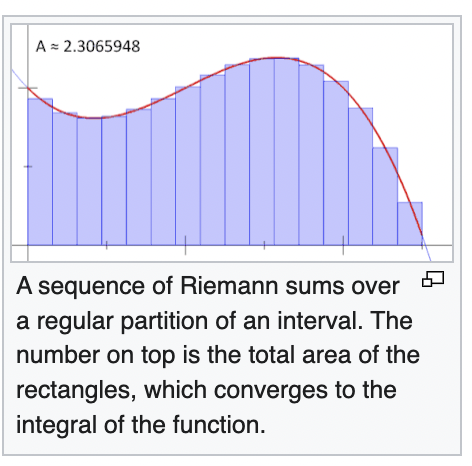

In Bayesian inference, the integrand is the joint distribution: $$p(\mathrm{fluxes}, \mathrm{images}) = p(\mathrm{images} \mid \mathrm{fluxes}) \, p(\mathrm{fluxes}).$$
Integrating over the fluxes gives us $p(\mathrm{images}).$
Then, using Bayes rule, we can solve for the posterior, i.e.,
$$p(\mathrm{fluxes} \mid \mathrm{images}) = \frac{p(\mathrm{images} \mid \mathrm{fluxes}) \, p(\mathrm{fluxes})}{p(\mathrm{images})}.$$

Let's do it! First, we need to decide where to evaluate the integrand. Below, `flux_grid` stores where (i.e., at what fluxes) we'll evaluate the integrand.

In [ ]:
bin_width = 100
grid_size = 5000
flux_grid = 0.1 * mean_star_flux + torch.arange(grid_size) * bin_width

To evaluate $p(image \mid fluxes)$ at these fluxes, we need to form a four-dimensional tensor, which below is called `star_rate`. The first dimension has length one: it will allow us to repeat a calculation for of the $n$ images subsequently through "broadcasting". (Both numpy and PyTorch support broadcasting.) The second and third dimensions of `star_rate` have length `img_dim`. The fourth dimension has length `grid_size`.

In [ ]:
star_rate = psf.view(1, img_dim, img_dim, 1) * flux_grid.view(1, 1, 1, grid_size)
star_rate += background_intensity
star_rate.shape

Next, to evaluate $p(image \mid fluxes)$, we use the `log_prob` function from PyTorch's `Poisson` class. `images` above is a three-dimensional tensor, but to support broadcasting, we expand it to four dimensions before evaluating the log probability. This returns a tensor with a (log) probability for each pixel, for each image, for each flux in the grid.

To the conditional log probability of each image, we sum of over the pixels (i.e., dimensions 1 and 2). Summing here is justified because the pixel intensities are conditionally independent given the flux.

In [ ]:
# conditional log likelihood (for each observed image and each flux grid point)
images4d = images.view(n, img_dim, img_dim, 1)
log_p_images_given_fluxes = Poisson(star_rate).log_prob(images4d).sum([1, 2])
assert log_p_images_given_fluxes.shape == (n, grid_size)

Now, we multiply the conditional likelihood by the prior to compute the joint likelihood. Our calculations all happen in "log space" to avoid numerical instability issues. This is considered good practice. Whenever possible, avoid explicitly multiple probabilities on a computer because the product may be so small that it will be rounded down to zero. It's preferable to sum log probabilities.

In [ ]:
# joint log probability
log_p_fluxes_and_images = log_p_images_given_fluxes + flux_prior.log_prob(flux_grid)
assert log_p_fluxes_and_images.shape == (n, grid_size)

At last, we can compute $p(fluxes \mid images)$ for each flux in the grid. The posterior is proportional to the joint distribution, so we can get the posterior probability normalizing the joint distribution across fluxes. Normalizing is performed on log-transformed inputs by the `softmax` operator.

In [ ]:
# posterior density
p_fluxes_given_images = log_p_fluxes_and_images.softmax(1)
assert p_fluxes_given_images.shape == (n, grid_size)

Comparing point estimates to the ground truth is one way to assess how well various inference methods are performing. Here we include two baseline estimators. The first baseline just predicts the mean of the prior distribution for each image. The second baseline subtracts off the background intensity and sums the flux over the pixels. The methods are compared in terms of root mean squared error (RMSE).

In [ ]:
def flux_rmse(est_fluxes):
    return (true_fluxes - est_fluxes).pow(2).mean().sqrt()

print(f"prior mean RMSE: {flux_rmse(flux_prior.mean)}")

ss_flux = (images - background_intensity).sum([1,2])
print(f"sky subtracted RMSE: {flux_rmse(ss_flux)}")

posterior_mean = (p_fluxes_given_images * flux_grid.view(1, grid_size)).sum(1)
print(f"grid posterior mean RMSE: {flux_rmse(posterior_mean)}")

**EXERCISE 3:** How does the accuracy of your estimates change if the bin width is 10000 and grid size is 50?

YOUR ANSWER HERE

**EXERCISE 4:** Try changing the seed a few times (set near the beginning of this notebook), and re-running this notebook. How often does the posterior mean outperform the "sky subtracted" baseline estimator?

YOUR ANSWER HERE

## Variational inference
Numerical integration works pretty well for low-dimensional latent variables, but as the dimension of the latent space grows, the number of samples (`grid_size`) required increases exponentially. Variational inference is a computationally efficient alternative.

Variational inference aims to find a distribution $q(\mathrm{flux})$ that minimizes $$\mathrm{KL}\left[ q(\mathrm{flux})\, \| \, p(\mathrm{flux} \mid \mathrm{images}) \right].$$
Below, we restrict $q$ to the the class of $n$-dimensional multivariate normal distributions that have a diagonal covariance matrix.
The approximation $q$ is parameterized by a mean and standard deviation that is unique to each image.
We compute stochastic gradients of the objective function using the reparameterization trick, and use stochastic gradient descent for optimization.

In [ ]:
# `sum([1, 2])` sums over dimensions 1 and 2 
q_mean = nn.Parameter((images - background_intensity).sum([1, 2]) + 5000)
q_sd = nn.Parameter(torch.ones(n) * 100)

optimizer = torch.optim.SGD([q_mean, q_sd], lr=100)
num_samples = 64  # number of samples of q per image

for i in range(3000):
    q = Normal(q_mean, q_sd.clamp(1e-4))
    z = q.rsample((num_samples,))
    zt = z.permute(1, 0)

    img_rate = psf.view(1, img_dim, img_dim, 1) * zt.view(n, 1, 1, num_samples)
    img_rate += background_intensity
    cond_ll = Poisson(img_rate)
    
    neg_elbo = q.log_prob(z).sum()
    neg_elbo -= flux_prior.log_prob(z).sum()
    neg_elbo -= cond_ll.log_prob(images.view(n, img_dim, img_dim, 1)).sum()
    
    if i % 200 == 0:
        obj = neg_elbo.item() / num_samples
        rmse = flux_rmse(q_mean)
        print(f"[{i}] objective: {obj}   rmse: {rmse}")
    
    optimizer.zero_grad()
    neg_elbo.backward()
    optimizer.step()

**EXERCISE 5:** PyTorch has excellent documentation. In the code above, what does [`clamp`](https://pytorch.org/docs/stable/generated/torch.clamp.html) do, and why might it be helpful here?

YOUR ANSWER HERE

**EXERCISE 6:** Above, what happens if you replace `rsample` with `sample`? Why does it happen?

YOUR ANSWER HERE

**EXERCISE 7:** What is the dimension of the `img_rate` variable above, and what is the length of each dimension? (PyTorch has a function called `size` that may be useful.) What do each of the dimensions correspond to?

YOUR ANSWER HERE

**EXERCISE 8:** Above, the negative ELBO (i.e., -1 * ELBO) is written as the sum of three statements. What mathematical expression do each of these three code statements implement? (You can use the dollar sign in Jupyter to write LaTeX equations, and you can see my slides or the bottom of page 6 in [this paper](https://arxiv.org/pdf/1601.00670.pdf) for a decomposition of the ELBO.)

YOUR ANSWER HERE

### Amortized variational inference

The approach above can be slow because it requires us to effectively solve a unique optimization problem for each image. Amortized inference is more efficient for large datasets. In amortized inference, the approximating distribution for each of the $n$ images is specified by shared neural network, called an encoder. The parameters/weights of the encoder are shared by all $n$ images.

In [ ]:
hidden_width = 64

class StarEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim * img_dim, hidden_width),
            nn.ReLU(),
            nn.Linear(hidden_width, hidden_width),
            nn.BatchNorm1d(hidden_width),
            nn.ReLU(),
            nn.Linear(hidden_width, 2),
        )
    
    def forward(self, x):
        x = x.view(-1, img_dim ** 2)
        out = self.net(x)
        q_mean = out[:, 0]
        q_sd = out[:, 1].clamp(-6, 6).exp()
        return Normal(q_mean, q_sd)
    

encoder = StarEncoder()
optimizer = torch.optim.SGD(encoder.parameters(), lr=1e-3)

mb = 8   # minibatch size
num_samples = 64  # number of samples of q per image in the minibatch

for i in range(30000):
    indices = torch.randint(n, (mb,))
    x = images[indices]

    q = encoder(x)

    z = q.rsample((num_samples,))
    zt = z.permute(1, 0)
    
    img_rate = psf.view(1, img_dim, img_dim, 1) * zt.view(mb, 1, 1, num_samples)
    img_rate = img_rate.clamp(0) + background_intensity
    cond_ll = Poisson(img_rate)

    neg_elbo = q.log_prob(z).sum()
    neg_elbo -= flux_prior.log_prob(z).sum()
    neg_elbo -= cond_ll.log_prob(x.view(mb, img_dim, img_dim, 1)).sum()

    if i % 500 == 0:
        obj = neg_elbo.item() * n / (mb * num_samples)
        rmse = flux_rmse(encoder(images).mean)
        print(f"[{i}] objective: {obj}   rmse: {rmse}")

    optimizer.zero_grad()
    neg_elbo.sum().backward()
    optimizer.step()

So far we've exclusively used the CPU for our neural network calculations rather than the GPU. Computers with a GPU could perform the training routine above between 10 and 100 times faster. But the current code is fast enough for our purposes today.

**EXERCISE 9:** Above, our encoder network uses hidden layers that are 64 units wide. What happens if you change the width to 8? What if you also increase the learning rate to `1e-2`?

YOUR ANSWER HERE

**EXERCISE 10:** The encoder above uses one batch norm layer. What happens if you remove this layer? What if you also decrease the learning rate to `1e-4`?

YOUR ANSWER HERE

**EXERCISE 11:** Try increasing the number of images `n` from 16 to 256, and rerunning this notebook. How much does the runtime of non-amortized variational infernce increase? Does the runtime of amortized variational inference increase?

YOUR ANSWER HERE

## Next Steps
If you're interested in reading about how variational inference has been applied in astronomy, here are several recent examples:
- [Regier et al (2019)](https://doi.org/10.1214/19-AOAS1258)
- [Mertsch & Vittino (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...655A..64M/abstract)
- [Ho et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...908..204H/abstract)